In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-trip-duration-prediction/For_modeling.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV

from sklearn.metrics.pairwise import haversine_distances
from math import radians, cos, sin, asin, sqrt

from pprint import pprint
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
import eli5
from eli5 import show_weights,show_prediction
import shap

In [3]:
data = pd.read_csv('/kaggle/input/seoul-bike-trip-duration-prediction/For_modeling.csv')

In [4]:
data.shape

(9601139, 26)

In [5]:
data.head()

,Unnamed: 0,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,...,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
0,0,3,50,37.544666,126.888359,37.544666,126.888359,0.000000,1,1,...,4,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
1,1,24,7670,37.506199,127.003944,37.551250,127.035103,5.713529,1,1,...,25,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
2,2,8,1390,37.544590,127.057083,37.537014,127.061096,0.913702,1,1,...,9,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
3,3,8,1820,37.571102,127.023560,37.561447,127.034920,1.468027,1,1,...,10,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0
4,4,4,850,37.573242,127.015907,37.565849,127.016403,0.823227,1,1,...,6,0,-3.2,0.0,0.5,40.0,0.0,0.0,-2.2,25.0


In [6]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [7]:
data.isnull().sum()

Duration      0
Distance      0
PLong         0
PLatd         0
DLong         0
DLatd         0
Haversine     0
Pmonth        0
Pday          0
Phour         0
Pmin          0
PDweek        0
Dmonth        0
Dday          0
Dhour         0
Dmin          0
DDweek        0
Temp          0
Precip        0
Wind          0
Humid         0
Solar         0
Snow          0
GroundTemp    0
Dust          0
dtype: int64

In [8]:
pd.set_option('display.max_columns', None)
data.describe()

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Pmonth,Pday,Phour,Pmin,PDweek,Dmonth,Dday,Dhour,Dmin,DDweek,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
count,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06,9.601139e+06
mean,2.580294e+01,3.713519e+03,3.754761e+01,1.269908e+02,3.754770e+01,1.269907e+02,1.870315e+00,7.578754e+00,1.576714e+01,1.437801e+01,2.914948e+01,2.943812e+00,7.579198e+00,1.576666e+01,1.442620e+01,2.999278e+01,2.945771e+00,1.856201e+01,1.784856e-02,1.819274e+00,5.397565e+01,7.300679e-01,9.948924e-03,2.072376e+01,3.245798e+01
std,2.504333e+01,3.956611e+03,4.441376e-02,8.257065e-02,4.445305e-02,8.323726e-02,1.995361e+00,2.696797e+00,8.748012e+00,6.249244e+00,1.725837e+01,1.976063e+00,2.696781e+00,8.747788e+00,6.484493e+00,1.730960e+01,1.977624e+00,9.498075e+00,3.736282e-01,9.710258e-01,1.742159e+01,9.175004e-01,1.628091e-01,1.265221e+01,2.407264e+01
min,1.000000e+00,1.000000e+00,3.743727e+01,1.267986e+02,3.743727e+01,1.267986e+02,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.780000e+01,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,-1.360000e+01,0.000000e+00
25%,8.000000e+00,1.230000e+03,3.751424e+01,1.269200e+02,3.751424e+01,1.269194e+02,6.758669e-01,6.000000e+00,8.000000e+00,1.000000e+01,1.400000e+01,1.000000e+00,6.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,1.000000e+00,1.220000e+01,0.000000e+00,1.100000e+00,4.100000e+01,0.000000e+00,0.000000e+00,1.160000e+01,1.600000e+01
50%,1.600000e+01,2.280000e+03,3.754693e+01,1.269943e+02,3.754655e+01,1.269947e+02,1.257498e+00,8.000000e+00,1.600000e+01,1.600000e+01,2.900000e+01,3.000000e+00,8.000000e+00,1.600000e+01,1.600000e+01,3.000000e+01,3.000000e+00,2.010000e+01,0.000000e+00,1.700000e+00,5.300000e+01,2.700000e-01,0.000000e+00,2.110000e+01,2.700000e+01
75%,3.600000e+01,4.620000e+03,3.757324e+01,1.270618e+02,3.757324e+01,1.270624e+02,2.363812e+00,1.000000e+01,2.300000e+01,1.900000e+01,4.400000e+01,5.000000e+00,1.000000e+01,2.300000e+01,2.000000e+01,4.500000e+01,5.000000e+00,2.550000e+01,0.000000e+00,2.400000e+00,6.700000e+01,1.260000e+00,0.000000e+00,2.850000e+01,4.200000e+01
max,1.190000e+02,3.329000e+04,3.768972e+01,1.271803e+02,3.768972e+01,1.271803e+02,2.863448e+01,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,6.000000e+00,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,6.000000e+00,3.940000e+01,3.500000e+01,7.400000e+00,9.800000e+01,3.520000e+00,8.800000e+00,6.220000e+01,3.040000e+02


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601139 entries, 0 to 9601138
Data columns (total 25 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Duration    int64  
 1   Distance    int64  
 2   PLong       float64
 3   PLatd       float64
 4   DLong       float64
 5   DLatd       float64
 6   Haversine   float64
 7   Pmonth      int64  
 8   Pday        int64  
 9   Phour       int64  
 10  Pmin        int64  
 11  PDweek      int64  
 12  Dmonth      int64  
 13  Dday        int64  
 14  Dhour       int64  
 15  Dmin        int64  
 16  DDweek      int64  
 17  Temp        float64
 18  Precip      float64
 19  Wind        float64
 20  Humid       float64
 21  Solar       float64
 22  Snow        float64
 23  GroundTemp  float64
 24  Dust        float64
dtypes: float64(13), int64(12)
memory usage: 1.8 GB


# Exploratory Data Analysis

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Duration'>

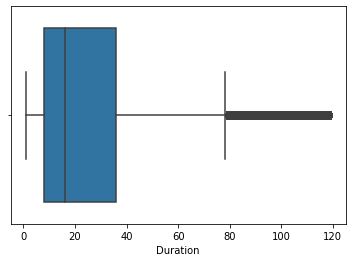

In [10]:
# Add a graph in each part
sns.boxplot(data["Duration"])

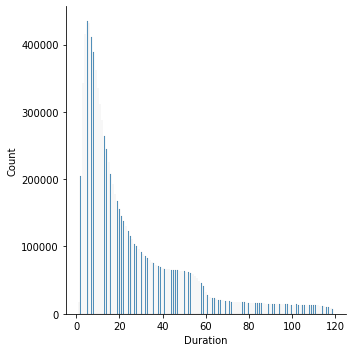

In [11]:
sns.displot(data["Duration"])

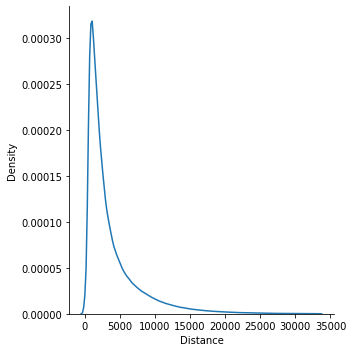

In [12]:
sns.displot(data['Distance'],kind='kde')

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Distance'>

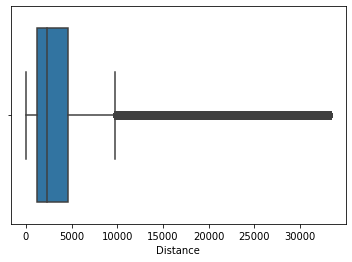

In [13]:
sns.boxplot(data['Distance'])

In [14]:
data['Snow'].value_counts()

0.0    9531693
0.3       9715
0.4       8624
1.0       4779
0.5       4529
0.7       3791
0.9       3278
1.6       3199
0.2       2535
3.5       2432
0.8       2232
0.6       2130
3.0       1798
1.3       1758
1.8       1685
2.5       1527
3.2       1451
1.1       1447
3.3       1341
2.2       1324
2.9       1189
0.1        912
3.7        831
2.3        805
3.6        676
2.4        661
4.1        632
2.8        522
5.0        471
1.7        451
1.5        437
6.0        385
3.4        372
8.8        280
3.8        277
7.0        274
2.6        218
1.4        199
4.0        105
2.0         99
7.1         39
3.9         36
Name: Snow, dtype: int64

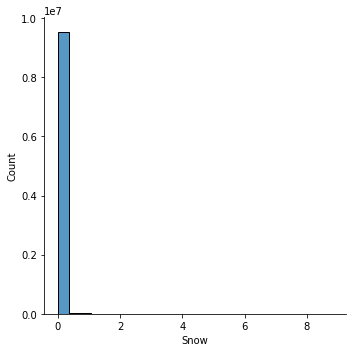

In [15]:
sns.displot(data['Snow'])

In [16]:
data['Precip'].value_counts()

0.0     9485238
0.5       38451
0.1       22246
1.0       10774
1.5        8483
2.0        4916
4.0        4609
0.2        4156
0.4        2723
0.9        2514
3.5        2277
0.3        1935
2.5        1364
1.3        1273
6.4        1014
1.1         958
21.5        694
3.0         682
5.0         662
4.5         654
7.3         573
5.5         449
6.5         406
1.6         377
0.8         329
1.8         274
18.0        273
13.5        249
11.5        194
3.3         181
8.0         180
13.0        176
5.4         170
29.5        152
35.0        147
7.0         145
9.5         144
18.5        130
6.0         107
9.0         105
1.4          99
10.5         72
4.9          70
24.0         65
1.2          57
19.0         52
8.5          45
9.1          39
2.4          36
3.7          34
17.0         31
10.0         29
1.9          23
21.0         20
14.5         19
12.5         17
15.5         15
12.0         12
7.5          10
16.0         10
Name: Precip, dtype: int64

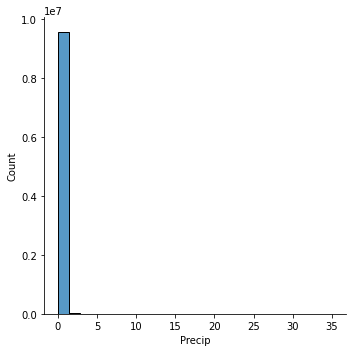

In [17]:
sns.displot(data['Precip'])

Snow and Precip can be dropped as more than 50 percent of values in this column are 0.

In [18]:
data['Solar'].value_counts()

0.00    3439939
0.01     166151
0.02     103065
0.03      99673
0.06      94949
         ...   
2.69       1454
3.38       1423
3.44       1389
2.97       1329
3.45        898
Name: Solar, Length: 345, dtype: int64

In [19]:
data['Haversine'].value_counts()

0.000000     955083
0.936970      13652
0.452993      10990
0.612179       8593
0.714991       8228
              ...  
8.850571          1
8.520064          1
10.239679         1
10.929690         1
8.779307          1
Name: Haversine, Length: 238583, dtype: int64

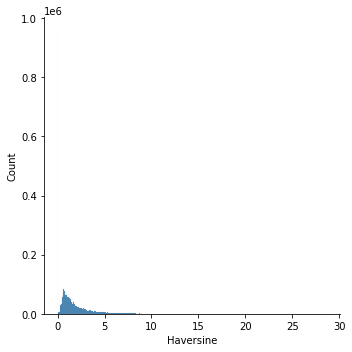

In [20]:
sns.displot(data['Haversine'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Haversine'>

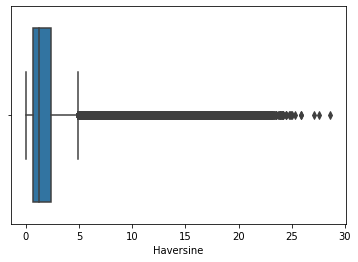

In [21]:
sns.boxplot(data['Haversine'])

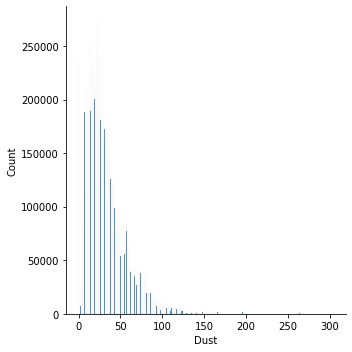

In [22]:
sns.displot(data['Dust'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Dust'>

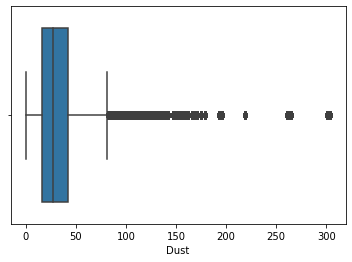

In [23]:
sns.boxplot(data['Dust'])

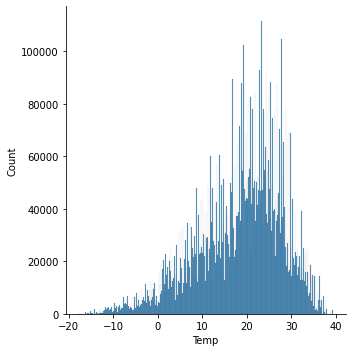

In [24]:
sns.displot(data['Temp'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Temp'>

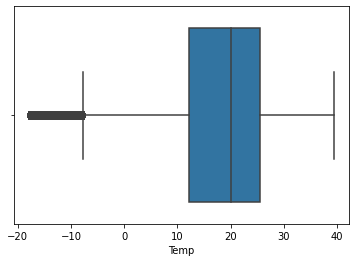

In [25]:
sns.boxplot(data['Temp'])

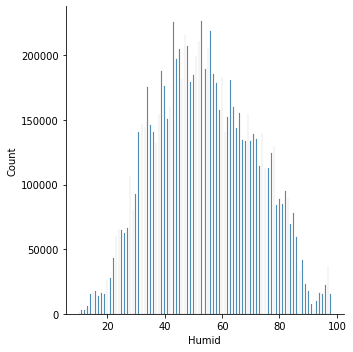

In [26]:
sns.displot(data['Humid'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='Humid'>

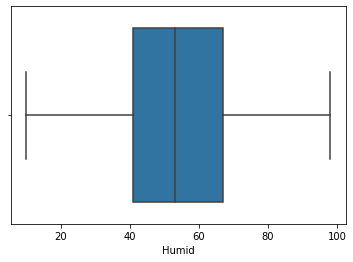

In [27]:
sns.boxplot(data['Humid'])

<AxesSubplot:>

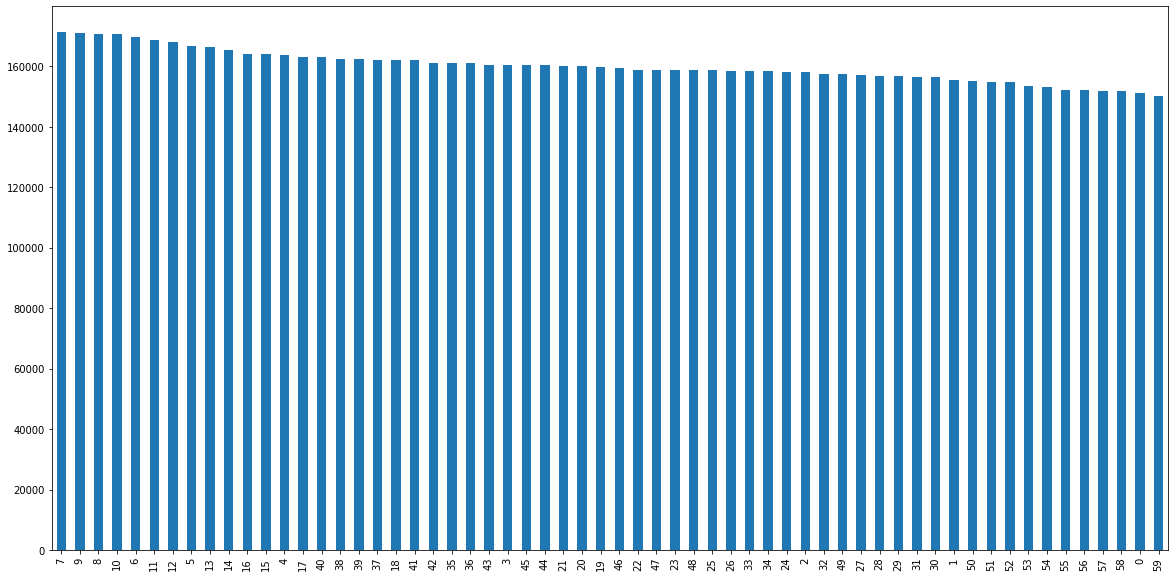

In [28]:
data['Pmin'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

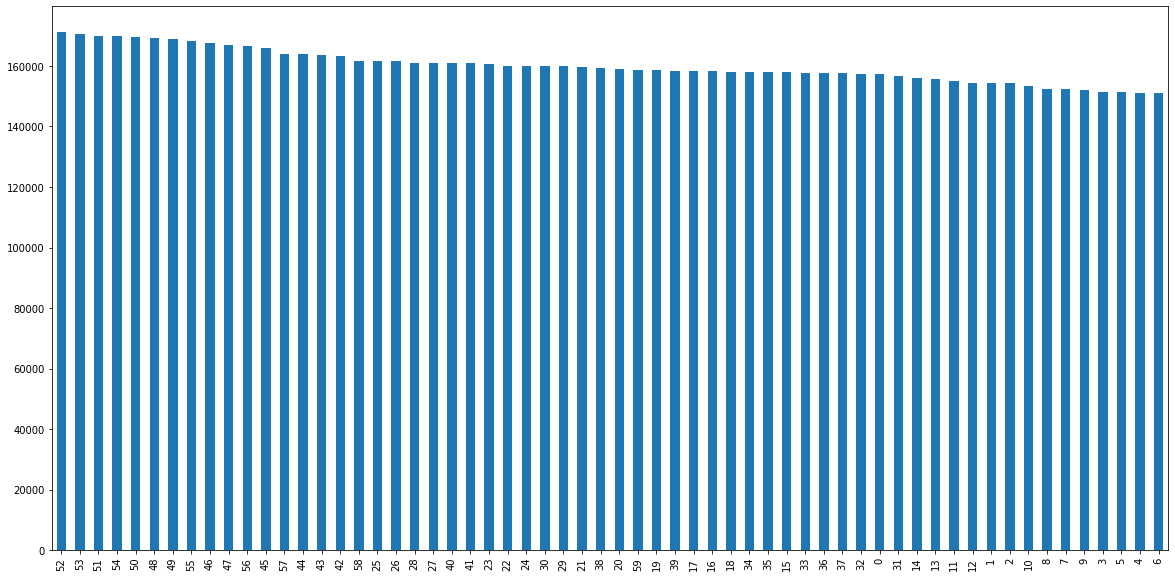

In [29]:
data['Dmin'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

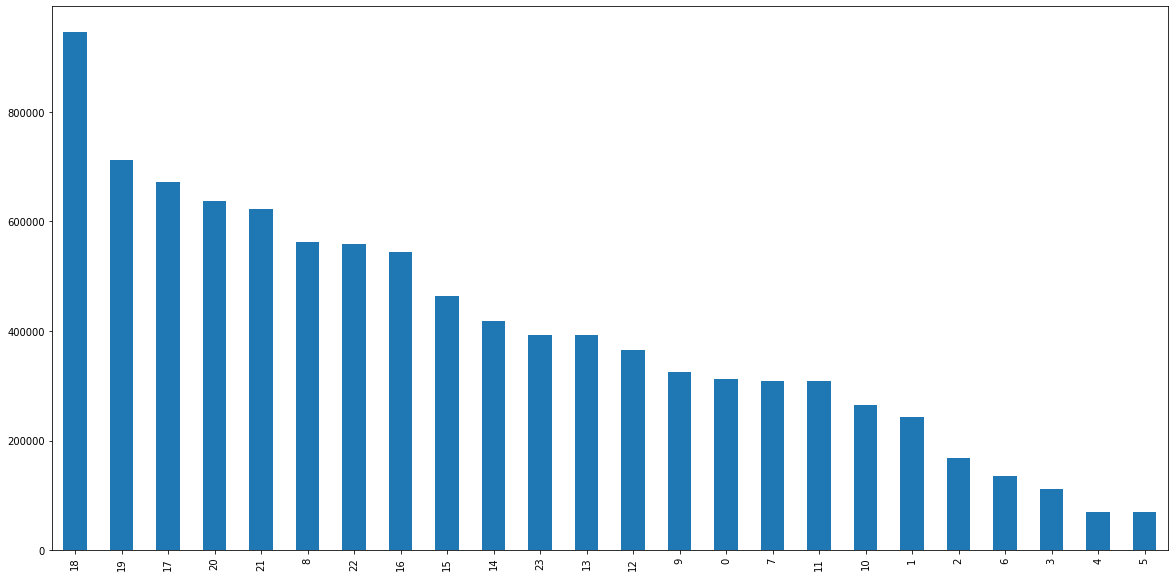

In [30]:
data['Phour'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

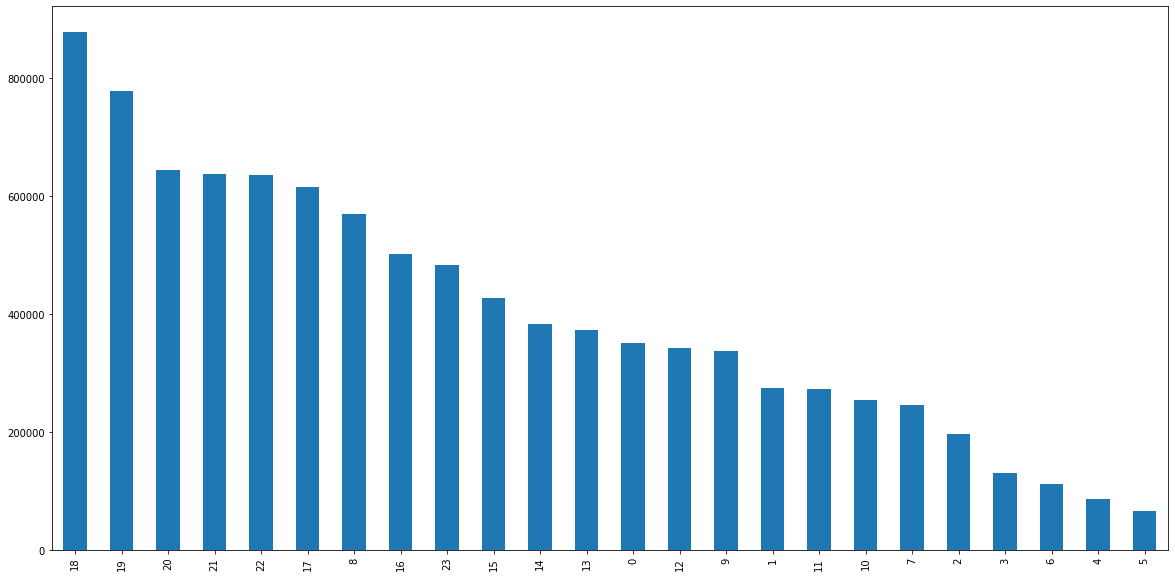

In [31]:
data['Dhour'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

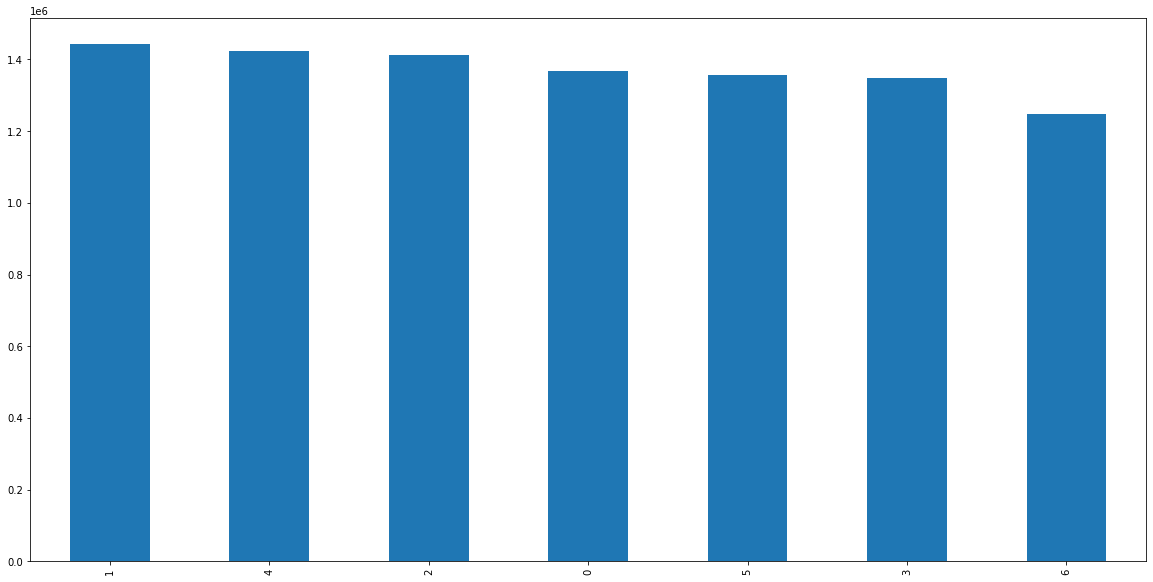

In [32]:
data['DDweek'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

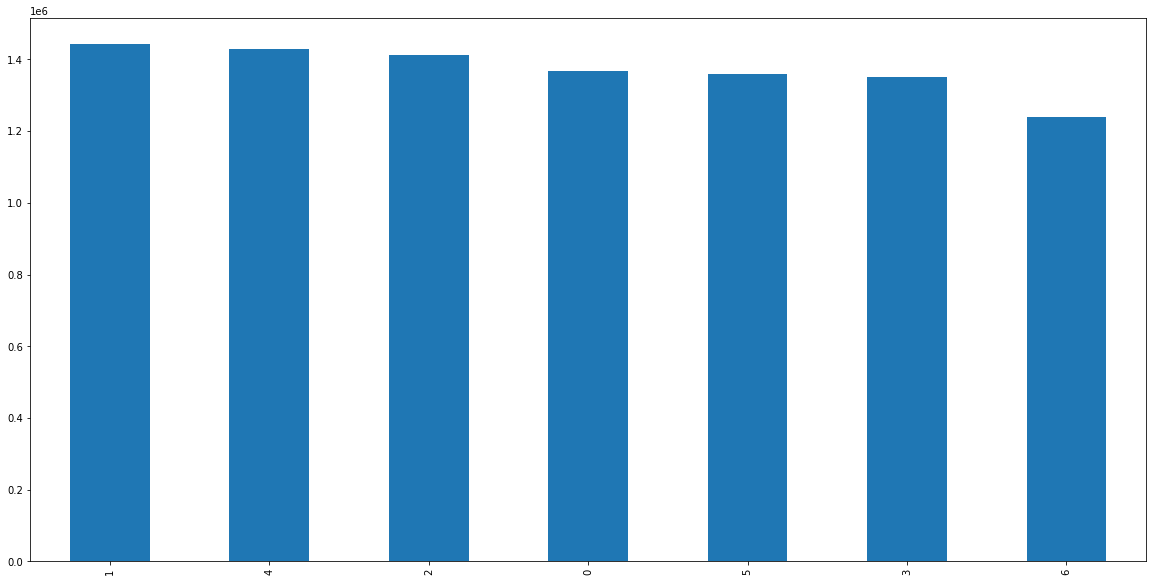

In [33]:
data['PDweek'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

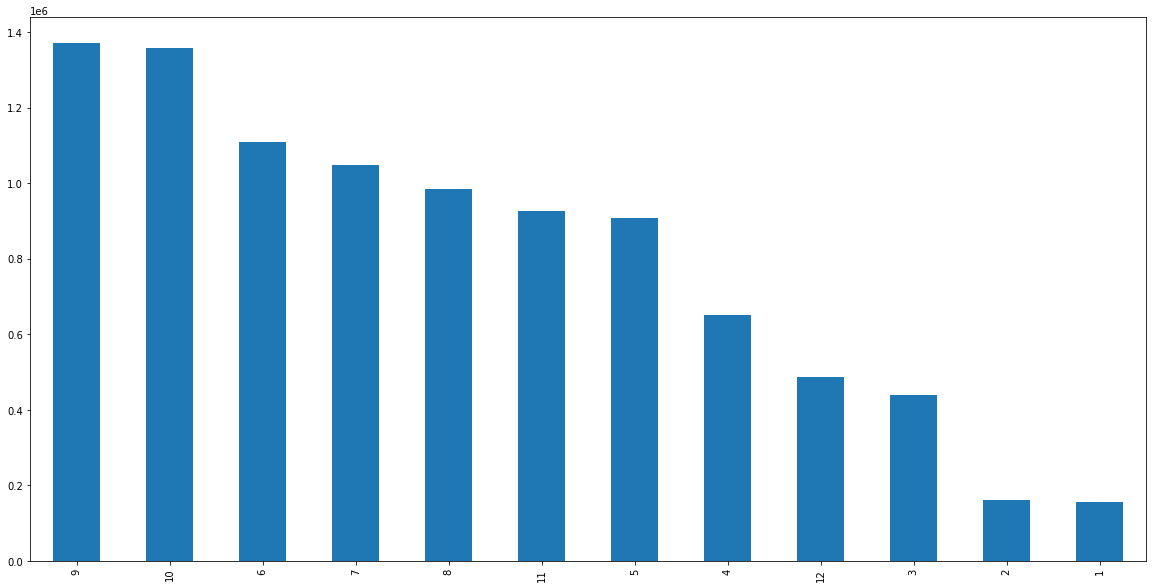

In [34]:
data['Pmonth'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

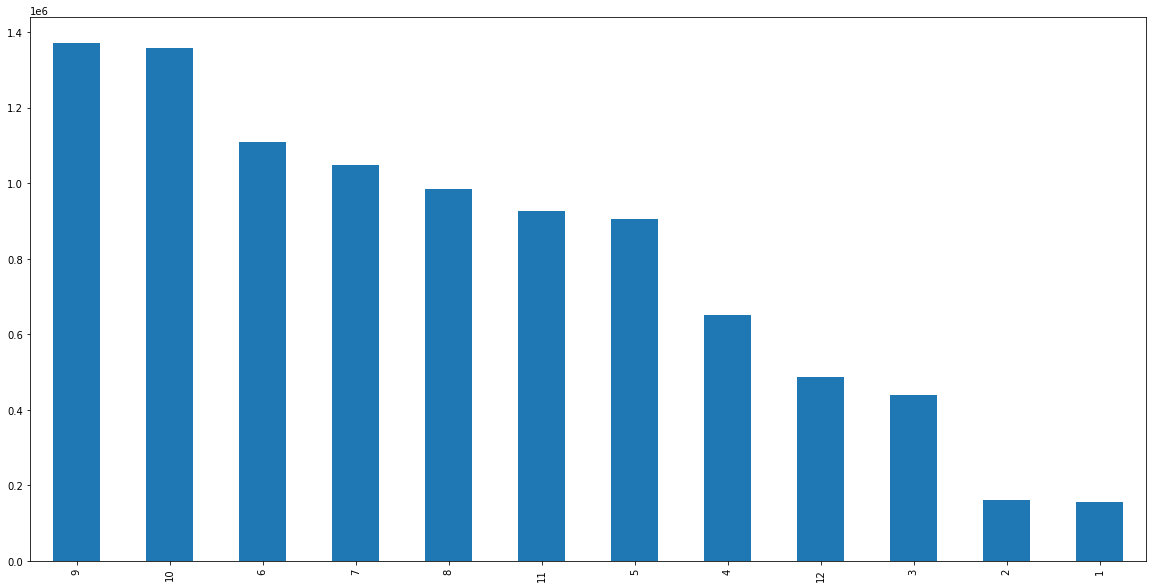

In [35]:
data['Dmonth'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

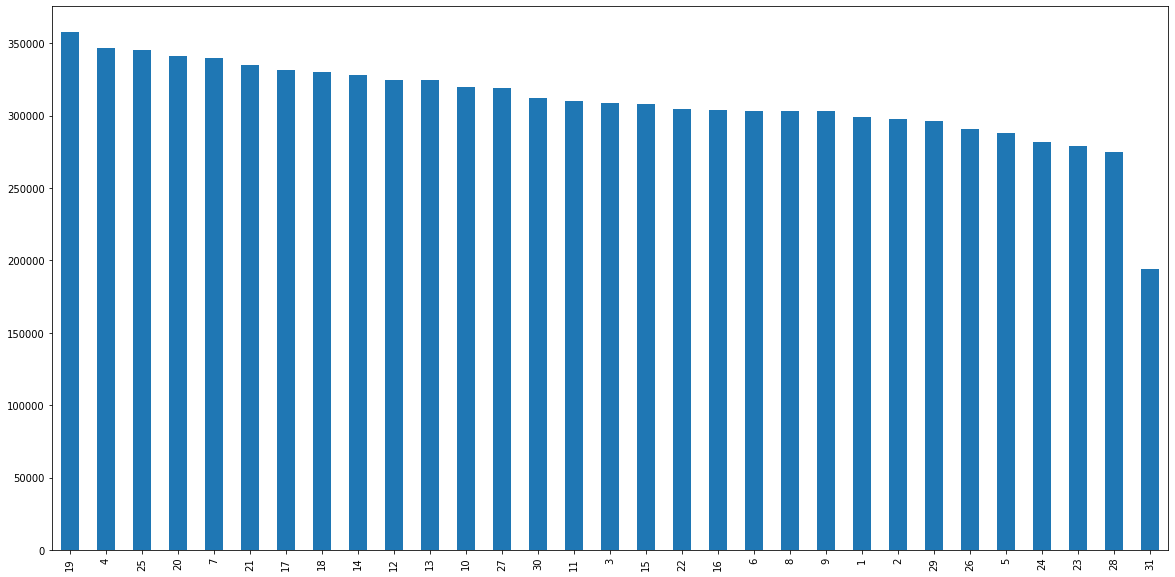

In [36]:
data['Pday'].value_counts().plot.bar(figsize=(20,10))

<AxesSubplot:>

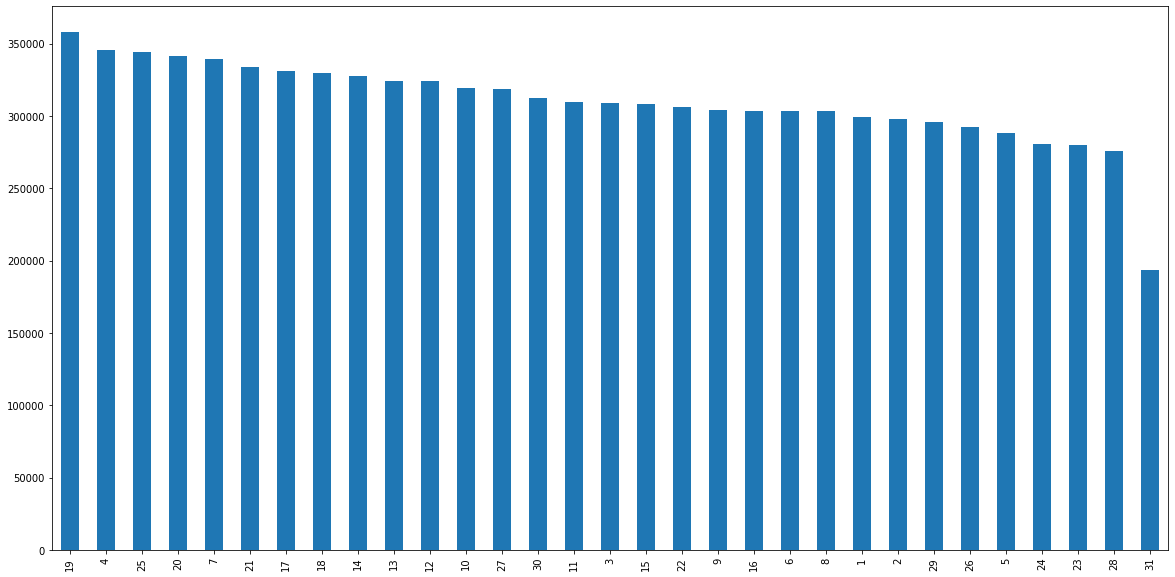

In [37]:
data['Dday'].value_counts().plot.bar(figsize=(20,10))

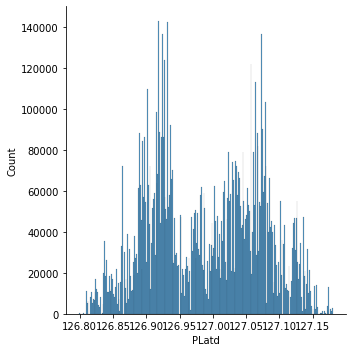

In [38]:
sns.displot(data['PLatd'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='PLatd'>

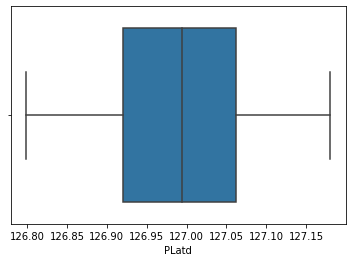

In [39]:
sns.boxplot(data['PLatd'])

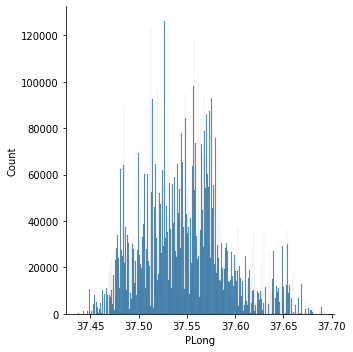

In [40]:
sns.displot(data['PLong'])

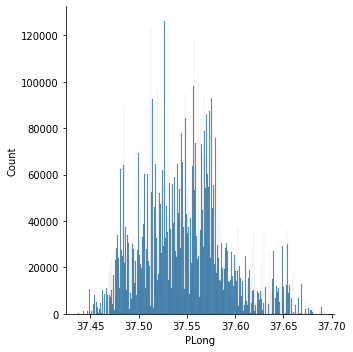

In [41]:
sns.displot(data['PLong'])

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='PLong'>

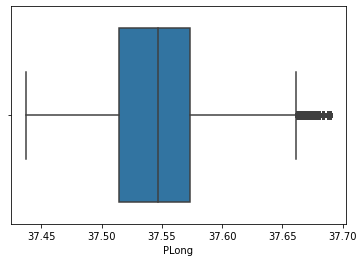

In [42]:
sns.boxplot(data['PLong'])

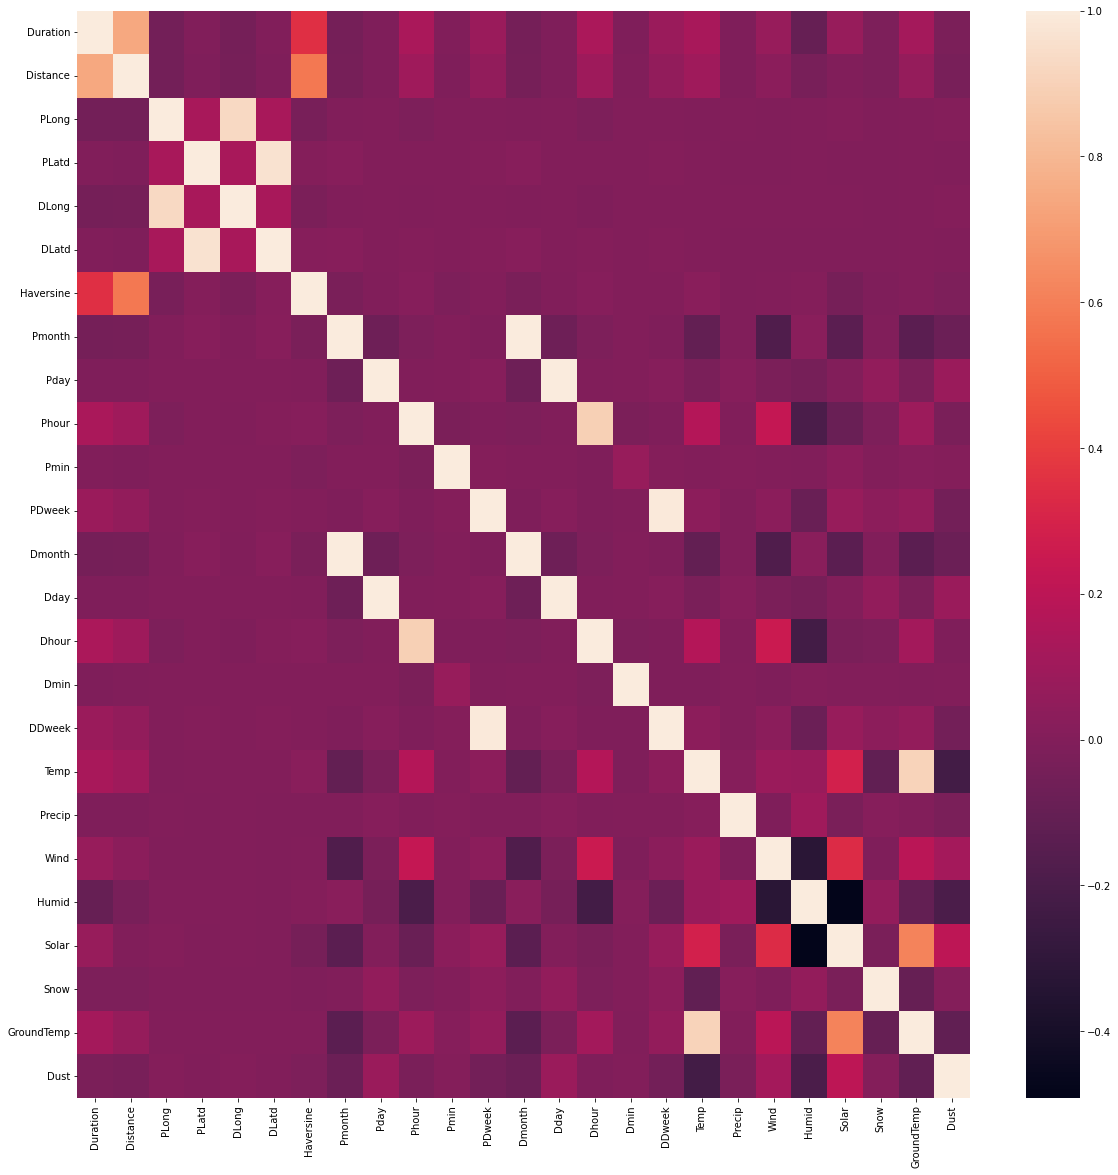

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=False)
plt.show()

Dmonth,Dday,Dhour,Dweekl,Dlat,Dlong,Snow,Precip,Groundtemp

# Feature Selection and Feature Engineering

In [44]:
data[['PLatd','PLong']] = data[['PLong','PLatd']]
data[['DLatd','DLong']] = data[['DLong','DLatd']]

In [45]:
data.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [46]:
data.drop(['DDweek','Temp','Snow','Precip','Dmonth','Dday','Dhour','PLatd','PLong','DLatd','DLong'],axis=1,inplace=True)
data = data.loc[data["Dust"] * data["Wind"] * data["Haversine"] * data["Solar"]!= 0.0]
data.reset_index(drop=True, inplace=True)

In [47]:
data_sample = data.sample(n=53609, replace=True,random_state=101)
data_sample.reset_index(drop=True,inplace=True)
data_sample

,Duration,Distance,Haversine,Pmonth,Pday,Phour,Pmin,PDweek,Dmin,Wind,Humid,Solar,GroundTemp,Dust
0,44,4990,1.501776,9,4,13,22,1,7,2.8,58.0,2.87,34.3,17.0
1,6,1540,1.301194,6,5,7,36,1,43,0.7,64.0,0.48,18.0,24.0
2,17,2400,1.929334,11,10,12,39,5,56,2.2,54.0,1.91,20.2,64.0
3,4,600,0.511734,3,20,15,23,1,28,3.3,39.0,1.21,10.7,20.0
4,10,1700,1.348312,9,27,11,49,3,0,1.7,43.0,2.42,29.9,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,33,6660,4.566863,12,31,18,14,0,49,1.7,27.0,0.02,-1.4,49.0
53605,45,5650,2.762302,10,9,12,47,1,33,0.6,40.0,1.82,24.1,24.0
53606,7,880,0.683929,7,13,18,22,4,30,2.5,60.0,1.43,30.7,16.0
53607,6,1540,1.185821,2,8,18,9,3,16,1.7,26.0,0.15,-0.5,45.0


In [48]:
X = data_sample.drop(labels=["Duration"], axis = 1)
y = data_sample["Duration"]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [50]:
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [51]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)

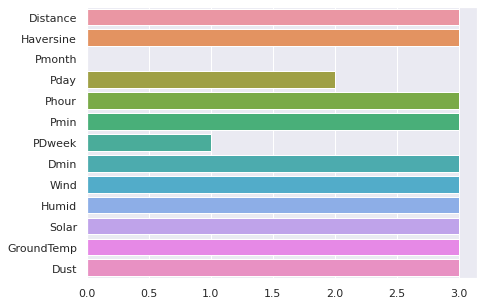

In [52]:
sns.set()
plt.figure(figsize=(7,5))
sns.barplot(y = X_train.columns, x = max(rfe.ranking_) - rfe.ranking_);

In [53]:
feature_list_rfe = [col for i,col in enumerate(X_train.columns) if rfe.support_[i]]
feature_list_rfe

['Distance',
 'Haversine',
 'Phour',
 'Pmin',
 'Dmin',
 'Wind',
 'Humid',
 'Solar',
 'GroundTemp',
 'Dust']

In [54]:
(X_train[feature_list_rfe].values == X_train_rfe).sum()

402060

# Training Linear Regression, XGBoost and Random Forest Model 

**Linear Regression Model using Standard Scaler with Outlier Treatment**

In [55]:
X_train_rfecp = X_train[feature_list_rfe].copy()
y_train_cp = y_train.copy()
# scaler = StandardScaler()
# scaler.fit(X_train_rfecp)
# X_test_cp = scaler.transform(X_test[feature_list_rfe])
X_test_cp = add_constant(X_test[feature_list_rfe])

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [56]:
X_train_rfecp = add_constant(X_train_rfecp)
reg = OLS(y_train_cp,X_train_rfecp).fit()

In [57]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Duration   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     5458.
Date:                Sun, 07 Nov 2021   Prob (F-statistic):               0.00
Time:                        07:24:26   Log-Likelihood:            -1.6758e+05
No. Observations:               40206   AIC:                         3.352e+05
Df Residuals:                   40195   BIC:                         3.353e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1886      0.652     -1.823      0.068      -2.467       0.089
Distance       0.0049   3.23e-05    152.333      0.000       0.005       0.005
Haversine     -0.6723      0.059    -11.339      0.000      -0.789      -0.556
Phour          0.6090      0.027     22.271      0.000       0.555       0.663
Pmin           0.0165      0.005      3.614      0.000       0.008       0.025
Dmin          -0.0055      0.005     -1.215      0.224      -0.014       0.003
Wind          -0.2423      0.093     -2.618      0.009      -0.424      -0.061
Humid         -0.0170      0.006     -2.636      0.008      -0.030      -0.004
Solar          2.0577      0.157     13.068      0.000       1.749       2.366
GroundTemp    -0.0181      0.010     -1.899      0.058      -0.037       0.001
Dust          -0.0057      0.003     -1.646      0.100      -0.013       0.001
==============================================================================
Omnibus:                    16868.225   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           392264.760
Skew:                           1.484   Prob(JB):                         0.00
Kurtosis:                      18.011   Cond. No.                     4.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
y_pred = reg.predict(X_test_cp)

In [59]:
print(f'Training score : {r2_score(y_train, reg.predict(X_train_rfecp))}')

print()
print('r2 score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Training score : 0.5759050103769907

r2 score: 0.563386552024741
MAE: 9.119844753479507
MSE: 239.51071531703923
RMSE: 15.476133732849403


In [60]:
delta = reg.predict(X_train_rfecp)-y_train

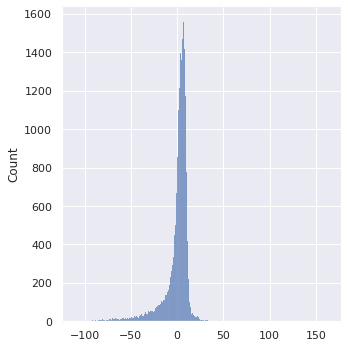

In [61]:
sns.displot(delta)

In [62]:
idx = delta[(delta>50)|(delta<-50)].index

In [63]:
len(idx)

920

In [64]:
X_train_rfecp2 = X_train_rfecp
y_train_cp2 = y_train_cp
X_train_rfecp2 = X_train_rfecp2[~X_train_rfecp2.index.isin(idx)].reset_index(drop=True)
y_train_cp2 = y_train_cp2[~y_train_cp2.index.isin(idx)].reset_index(drop=True)

In [65]:
y_train_cp

0         5
1        10
2        12
3        22
4        22
         ..
40201    29
40202    20
40203     6
40204    31
40205    10
Name: Duration, Length: 40206, dtype: int64

In [66]:
X_train_rfecp2

,const,Distance,Haversine,Phour,Pmin,Dmin,Wind,Humid,Solar,GroundTemp,Dust
0,1.0,1740,1.345114,8,16,22,1.1,65.0,0.01,-0.4,48.0
1,1.0,1860,1.565690,8,49,59,0.6,83.0,0.23,20.6,24.0
2,1.0,1600,1.210022,16,39,52,1.6,44.0,2.20,46.8,6.0
3,1.0,3410,2.429908,17,50,13,2.8,34.0,0.28,-0.1,37.0
4,1.0,2980,2.303346,9,31,53,1.1,59.0,1.80,32.5,49.0
...,...,...,...,...,...,...,...,...,...,...,...
39281,1.0,1560,0.194697,11,59,19,0.8,46.0,1.57,16.0,71.0
39282,1.0,3640,2.942890,11,47,9,1.0,43.0,1.52,42.1,27.0
39283,1.0,540,0.379138,17,25,32,2.2,51.0,0.98,42.1,51.0
39284,1.0,2000,0.827979,14,13,45,1.2,30.0,1.40,7.2,49.0


In [67]:
reg3 = OLS(y_train_cp2,X_train_rfecp2).fit()

In [68]:
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Duration   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                 1.212e+04
Date:                Sun, 07 Nov 2021   Prob (F-statistic):               0.00
Time:                        07:24:32   Log-Likelihood:            -1.4892e+05
No. Observations:               39286   AIC:                         2.979e+05
Df Residuals:                   39275   BIC:                         2.980e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4475      0.451     -3.207      0.001      -2.332      -0.563
Distance       0.0058   2.53e-05    230.629      0.000       0.006       0.006
Haversine     -1.7785      0.044    -39.999      0.000      -1.866      -1.691
Phour          0.4915      0.019     25.969      0.000       0.454       0.529
Pmin           0.0125      0.003      3.960      0.000       0.006       0.019
Dmin           0.0017      0.003      0.557      0.577      -0.004       0.008
Wind          -0.1305      0.064     -2.031      0.042      -0.256      -0.005
Humid         -0.0154      0.004     -3.446      0.001      -0.024      -0.007
Solar          1.4555      0.109     13.328      0.000       1.241       1.670
GroundTemp    -0.0098      0.007     -1.491      0.136      -0.023       0.003
Dust          -0.0056      0.002     -2.311      0.021      -0.010      -0.001
==============================================================================
Omnibus:                    12331.788   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59369.915
Skew:                           1.453   Prob(JB):                         0.00
Kurtosis:                       8.275   Cond. No.                     4.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
X_test_cp = add_constant(X_test[feature_list_rfe])
y_pred3 = reg3.predict(X_test_cp)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [70]:
print(f'Training score : {r2_score(y_train_cp2, reg3.predict(X_train_rfecp2))}')
print()
print('r2 score:', r2_score(y_test, y_pred3))
print('MAE:', mean_absolute_error(y_test, y_pred3))
print('MSE:', mean_squared_error(y_test, y_pred3))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred3)))

Training score : 0.7552838598801509

r2 score: 0.5491073872217267
MAE: 8.419123893521633
MSE: 247.34376075336223
RMSE: 15.727166329423817


**Random Forest Regressor**

In [71]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

rf.fit(X_train_rfe, y_train)
y_hat_test = rf.predict(X_test_rfe)

# rf.fit(X_train,y_train)
# y_pred = rf.predict(X_test)

In [72]:
y_hat_train = rf.predict(X_train_rfe)

In [73]:
y_hat_train

array([ 6.815,  9.745, 12.005, ...,  5.265, 37.46 , 11.975])

In [74]:
print(f'Training score : {rf.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test))
print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

Training score : 0.9613264453620755

r2 score: 0.7075170164750821
MAE: 6.753723047079012
MSE: 160.4458335559203
RMSE: 12.666721499895713


Text(0, 0.5, 'Predicted')

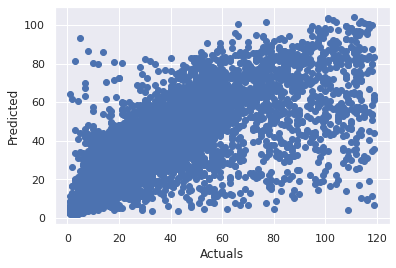

In [75]:
plt.scatter(y_test,y_hat_test)
plt.xlabel('Actuals')
plt.ylabel('Predicted')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


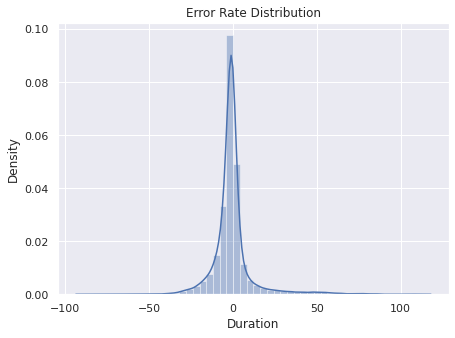

In [76]:
plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_test)
plt.title("Error Rate Distribution");

In [77]:
# # plt.scatter(y_test,y_hat_test)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

**XGBoost Regressor**

In [78]:
xgb = XGBRegressor()
xgb.fit(X_train_rfe, y_train)
y_hat_test = xgb.predict(X_test_rfe)

In [79]:
print(f'Training score : {xgb.score(X_train_rfe, y_train)}')

print()
print('r2 score:', r2_score(y_test, y_hat_test))
print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('MSE:', mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_hat_test)))

Training score : 0.8690685885236042

r2 score: 0.7458338656026084
MAE: 6.122131921684489
MSE: 139.4265635682746
RMSE: 11.807902589718234


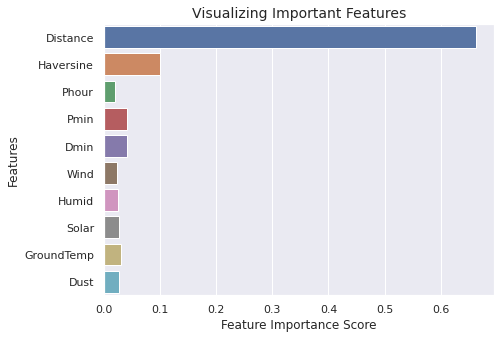

In [80]:
plt.figure(figsize=(7,5))
sns.barplot(x = rf.feature_importances_, y = feature_list_rfe)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", size=14);

# Hyperparameter Tuning Using Random Search

In [81]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [82]:
params = {'bootstrap': [True, False],
 'max_depth': [10, 50, 100,None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 2000]}

In [83]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 1000, 2000]},
                   random_state=42, verbose=2)

In [84]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

# Explainable AI using ELI5 and SHAP

In [85]:
rf1 = RandomForestRegressor()
xgb1 = XGBRegressor()
rf1.fit(X_train,y_train)
xgb1.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

**ELI5**

In [86]:
import eli5
from eli5 import show_weights

In [87]:
show_weights(rf1, feature_names=list(X.columns),show=["feature_importances"])

Weight,Feature
0.6589 ± 0.0106,Distance
0.0961 ± 0.0073,Haversine
0.0373 ± 0.0054,Dmin
0.0362 ± 0.0054,Pmin
0.0261 ± 0.0049,GroundTemp
0.0232 ± 0.0046,Solar
0.0224 ± 0.0049,Dust
0.0222 ± 0.0039,Humid
0.0199 ± 0.0037,Wind
0.0186 ± 0.0036,Phour


In [88]:
show_weights(xgb1, feature_names=list(X.columns),show=["feature_importances"])

Weight,Feature
0.5223,Distance
0.0888,Haversine
0.0577,Dmin
0.0528,Phour
0.0516,Pmin
0.0361,PDweek
0.0329,GroundTemp
0.0318,Solar
0.0304,Dust
0.0298,Humid


In [89]:
import random

In [90]:
eli5.show_prediction(xgb1, X_test.iloc[1,:], feature_names=list(X_test.columns), show_feature_values=True)

In [91]:
eli5.show_prediction(xgb1, X_test.iloc[2,:], feature_names=list(X_test.columns), show_feature_values=True)

In [92]:
eli5.show_prediction(xgb1, X_test.iloc[10,:], feature_names=list(X_test.columns), show_feature_values=True)

**SHAP**

In [93]:
shap_values = shap.TreeExplainer(rf1).shap_values(X_train[:10])

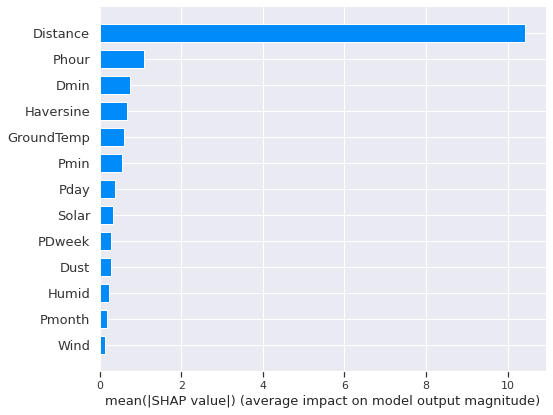

In [94]:
shap.summary_plot(shap_values, X_train[:10], plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


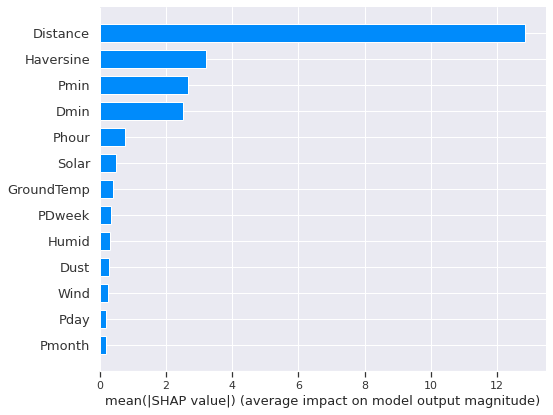

In [95]:
shap_values = shap.TreeExplainer(xgb1).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

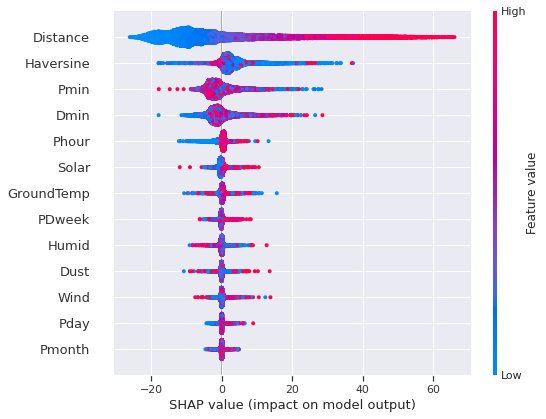

In [96]:
shap.summary_plot(shap_values, X_train)

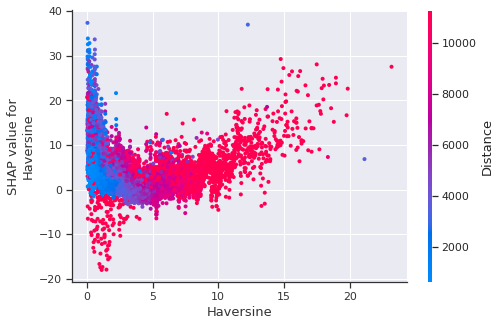

In [97]:
shap.dependence_plot('Haversine', shap_values, X_train)

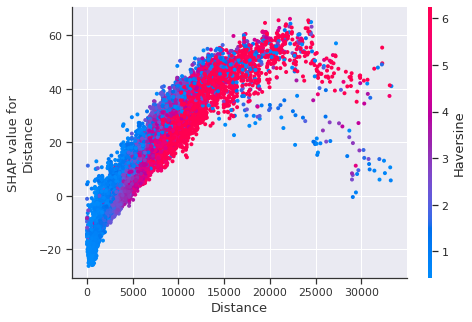

In [98]:
shap.dependence_plot('Distance', shap_values, X_train)

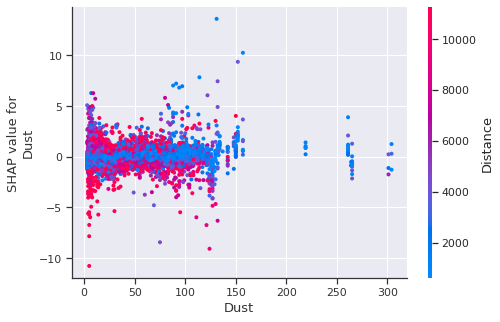

In [99]:
shap.dependence_plot('Dust', shap_values, X_train)

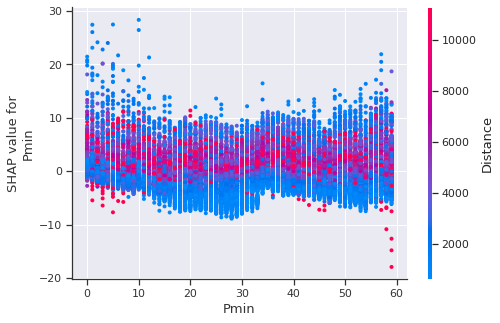

In [100]:
shap.dependence_plot('Pmin', shap_values, X_train)